<h1>Task 3.1</h1>

In [1]:
import numpy as np
import sklearn
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
from sklearn.feature_selection import r_regression
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectPercentile
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

<h2>Importing the Data</h2>
First, we import the data.

Note: It seems there is a bug in NumPy that causes the missing_values and filling_values parameters of genfromtxt to not behave as described. Therefore, as a work around I have used a SimpleImputer in my gwp_encoder function to replaced blank characters with 'nan' strings to make it simpler to cast the data to float64 before further processing.

In [4]:
#To make it easier to consistently load the csvs across all tasks.
def load_gwp(path):
    return (np.genfromtxt(path, dtype=str, delimiter=',',
                          skip_header=1, encoding="utf-8"),  
            np.genfromtxt(path, dtype=str, delimiter=',',
                          max_rows=1, encoding="utf-8").astype(str))

def load_star(path):
    return (np.genfromtxt(path, dtype=str, delimiter=',',
                          skip_header=1, encoding="utf-8"),
           np.genfromtxt(path, dtype=str, delimiter=',',
                         max_rows=1, encoding="utf-8").astype(str))

<h2>GWP Preprocessing and Transformation</h2>
In this section, we will do the preprocessing and transformation for the GWP dataset. This consists of the following stages:
<ul>
    <li>Encoding the data as arrays of floating point values</li>
    <li>Imputing missing values</li>
    <li>Feature selection</li>
    <li>Scaling the data</li>
</ul>

<h3>Encoding GWP</h3>
First, we transform the data from strings into appropriate numerical types for preprocessing and transformation.

The Kaggle page from which the garment worker productivity dataset was taken shows us that all but the first four features (date, quarter, department, and day) are already encoded into appropriate numerical representations so we simply cast them to floats. Quarter, department, and day can easily be encoded with an ordinal encoder. We'll write our own encoder for dates.

In [5]:
gwp_dataset, gwp_feature_names = load_gwp("gwp_assessment.csv")

In [7]:
#First, some useful functions.
#Maps date given as MM/DD/YYYY to ISO format.
def US_to_ISO_date(date):
    components = date.split('/')
    return components[2] + '-' + components[0] + '-' + components[1]

#Splits ISO date strings as arrays of years, months, and days.
def split_dates(datetimes, iso_converter=None, missing_value='', filling_value='nan'):
    datetimes = datetimes.copy()
    #Convert non-missing values to ISO format dates if converter is given.
    if(iso_converter != None):
        datetimes = np.array(list(map(
            lambda x: x if x == missing_value else iso_converter(x),
            datetimes)))
    #Encode missing dates as arrays of the filling value, otherwise ISO date.    
    split_dates = np.array(list(map(
        lambda x: [filling_value, filling_value, filling_value] if x == missing_value
                  else x.split('-'),
            datetimes)))    

    return np.array(split_dates)

Now we'll put everything together to make an encoder for gwp samples. We will encode missing elements as NaN values.

In [9]:
def gwp_encoder(gwp_dataset, missing_value='', filling_value='nan'):
    #Impute missing values to NaN values for casting.
    gwp_dataset = SimpleImputer(missing_values=missing_value,
                                strategy='constant',
                                fill_value=filling_value).fit_transform(
                                    gwp_dataset.astype('object'))
    #Split dates
    dates = split_dates(gwp_dataset[:, 0], iso_converter=US_to_ISO_date,
                        missing_value=filling_value,
                        filling_value=filling_value).astype('float64')
    #Encode Quarter, Department, and Day.
    ordinal_features = OrdinalEncoder().fit_transform(
        gwp_dataset[:, 1:4]).astype('float64') 
    #Rest as floats
    real_features = gwp_dataset[:, 4:].astype('float64')
    
    return np.hstack((dates, ordinal_features, real_features))
    

In [10]:
gwp_encoded = gwp_encoder(gwp_dataset, filling_value='nan')
#feature names now date is split
gwp_feature_names_split = np.concatenate(
    (np.array(["year", "month", "day(date)"]), gwp_feature_names[1:]))

<h3>Imputation</h3>
The gwp dataset has a number of missing values. The following graph displays the number of missing elements from each feature.

In [11]:
def count_nan_values(dataset):
    missing_values = np.zeros(dataset.shape[1])
    for i in range(0, dataset.shape[1]):
        for j in range(0, dataset.shape[0]):
            if np.isnan(dataset[j, i]):
                missing_values[i] = missing_values[i] + 1
    return missing_values


[]

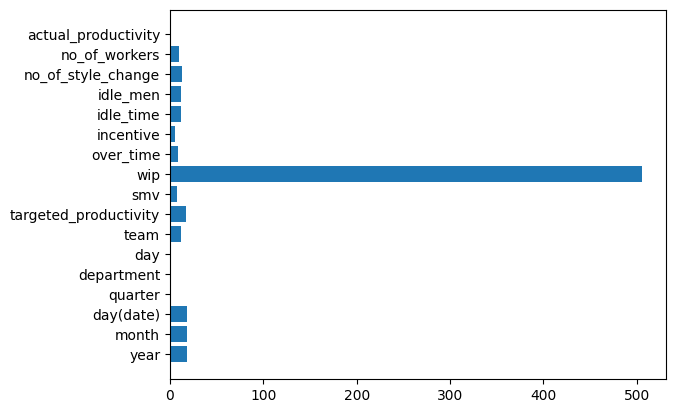

In [12]:
missing_gwp_fig, missing_gwp_ax = plt.subplots()
missing_gwp_ax.barh(gwp_feature_names_split, count_nan_values(gwp_encoded)) 
plt.plot()

In [13]:
print("Number of missing entries per feature")
for i in range(0, gwp_feature_names.size):
    print(gwp_feature_names[i] + ": " + str(count_nan_values(gwp_encoded)[2+i]))

Number of missing entries per feature
date: 18.0
quarter: 0.0
department: 0.0
day: 0.0
team: 12.0
targeted_productivity: 17.0
smv: 8.0
wip: 506.0
over_time: 9.0
incentive: 5.0
idle_time: 12.0
idle_men: 12.0
no_of_style_change: 13.0
no_of_workers: 10.0
actual_productivity: 0.0


<h4>Imputation Strategy</h4>
We'll try several imputation strategies, including univariate imputation and multivariate KNN imputation. To assess their effectiveness, we'll compare feature distributions before and after imputation. We're looking for imputations which keep the resulting distribution as similar to the original distribution as possible.

We define a function to automate the plotting of frequency distributions.

In [23]:
def plot_frequency_histograms(original_data, feature_names, imputed_data=None, n_bins=30):
    fig, axs = plt.subplots(original_data.shape[1], 1, figsize=(14, 8 * original_data.shape[1]))
    for feature in range(0, original_data.shape[1]):
        axs[feature].set_title(feature_names[feature])
        axs[feature].set_xlabel("Value")
        axs[feature].set_ylabel("Frequency")
        if(not (imputed_data is None)):
            axs[feature].hist([original_data[:, feature], imputed_data[:, feature]], bins=n_bins, label=['original', 'imputed'])
            axs[feature].legend()
        else:
            axs[feature].hist(original_data[:, feature], bins=n_bins)

<h4>Univariate Imputation</h4>
<h5>Mean Imputation</h5>
We'll start with univariate imputation using the mean of each feature.

In [24]:
mean_imputer = SimpleImputer(missing_values=np.nan, strategy="mean", copy=True)
mean_imputed_gwp = mean_imputer.fit_transform(gwp_encoded)

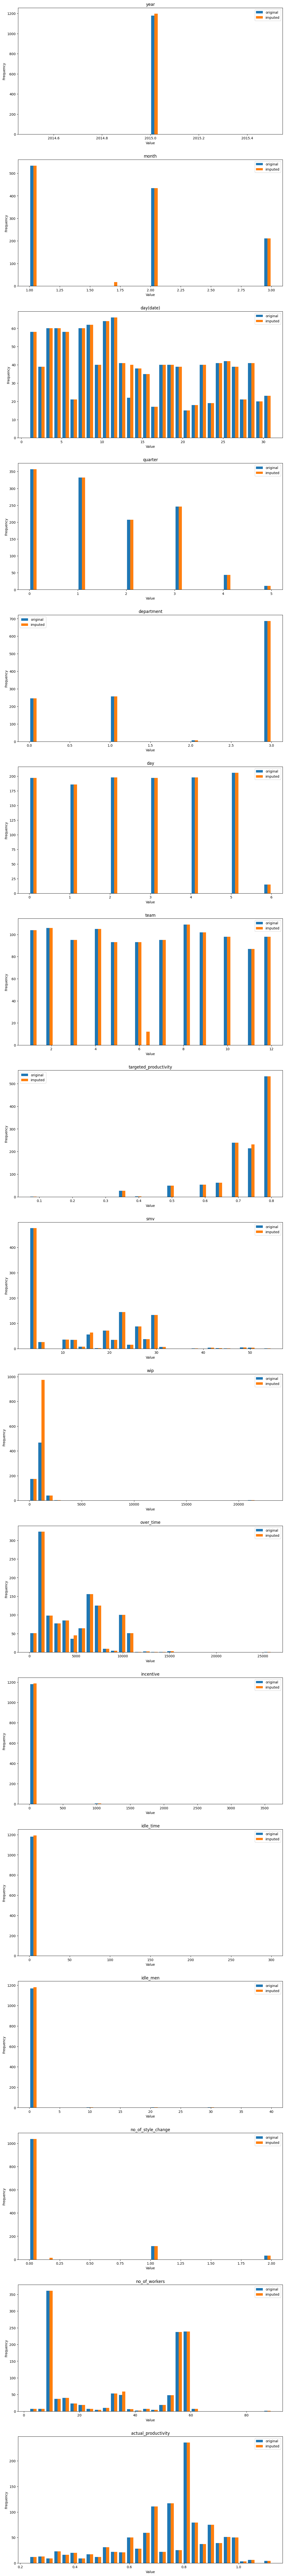

In [25]:
plot_frequency_histograms(gwp_encoded, gwp_feature_names_split, mean_imputed_gwp, 30)

Mean imputation mostly keeps the shapes of the distributions. It does however cause a large spike in the WIP feature which distorts the distribution quite a bit. 

<h5>Mode Imputation</h5>
We'll try using the mode instead.

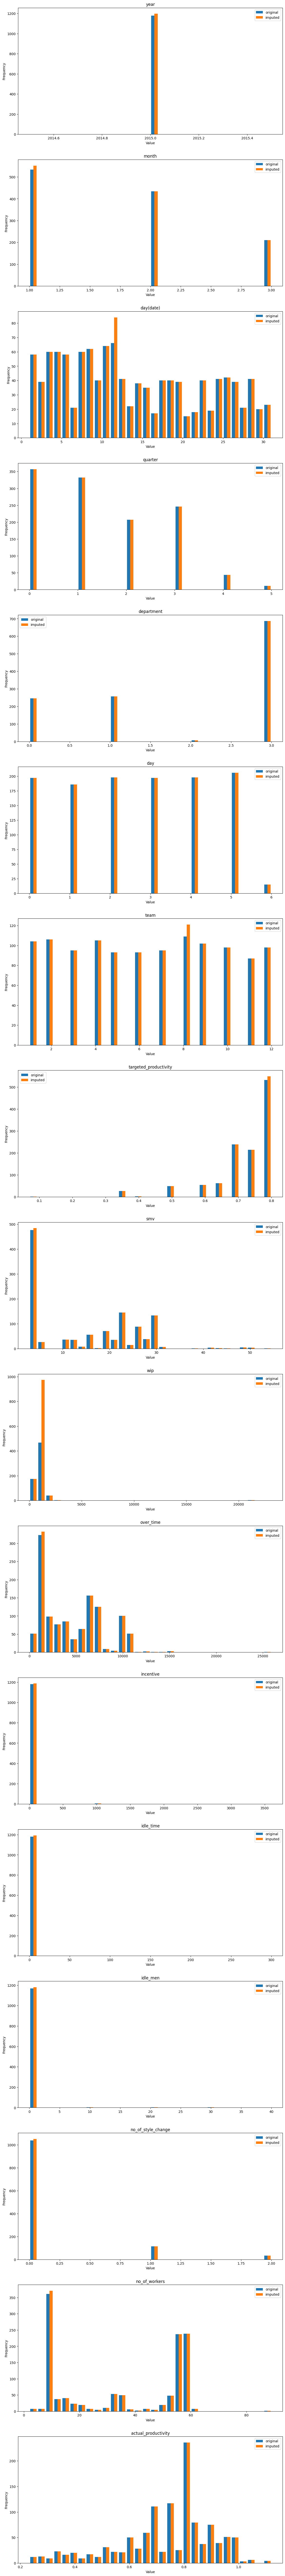

In [26]:
mode_imputer = SimpleImputer(missing_values=np.nan, strategy="most_frequent", copy=True)
mode_imputed_gwp = mode_imputer.fit_transform(gwp_encoded)
plot_frequency_histograms(gwp_encoded, gwp_feature_names_split, mode_imputed_gwp, 30)

We still get 'spikes' in the distributions and more so than in mean these tend to end up increasing the prevelance of already high frequency feature values. 

<h4>Multivariate Imputing</h4>
<h5>KNN Imputation</h5>
We'll now try multivaraite imputing using the KNN imputer.

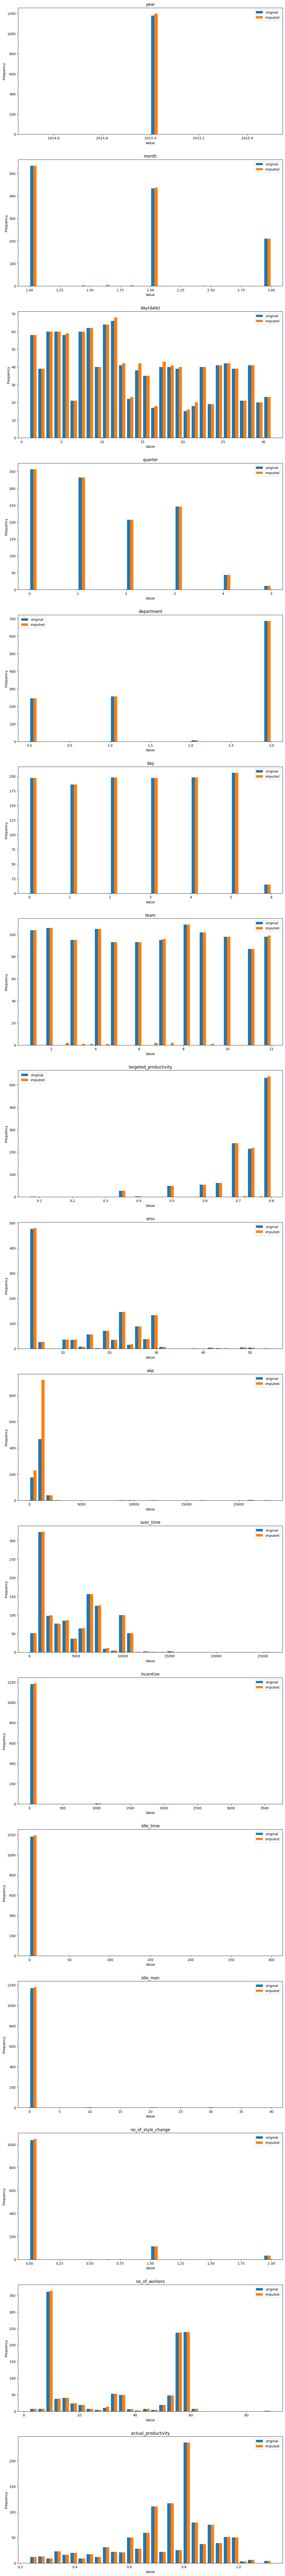

In [27]:
knn5_imputer = KNNImputer(missing_values=np.nan, n_neighbors=5, copy=True)
knn5_imputed_gwp = knn5_imputer.fit_transform(gwp_encoded)
plot_frequency_histograms(gwp_encoded, gwp_feature_names_split, knn5_imputed_gwp, n_bins=30)

Distributions retain shape an imputations are more evenly spread across the each feature's range of values which helps reduce 'spikes'. Based on the more even distribution of imputed values, we choose multivaraite imputing.

In [28]:
final_imputed_gwp = knn5_imputed_gwp

<h3>Feature Selection</h3>
With our imputed data, we begin feature selection using filter methods. We will select the features with the greatest pearson correlation with the target.

We make a function to plot features against the target and calculate their Pearson coefficients.

In [30]:
def plot_pearson(X, y, feature_names):
    pc_scores = r_regression(X, y)
    fig, axs = plt.subplots(X.shape[1], 1, figsize=(14, 8 * X.shape[1]))
    for feature in range(0, X.shape[1]):
        axs[feature].set_title(feature_names[feature] + " correlation: " + str(pc_scores[feature]))
        axs[feature].set_xlabel(feature_names[feature])
        axs[feature].set_ylabel("target")
        axs[feature].plot(X[:, feature], y)

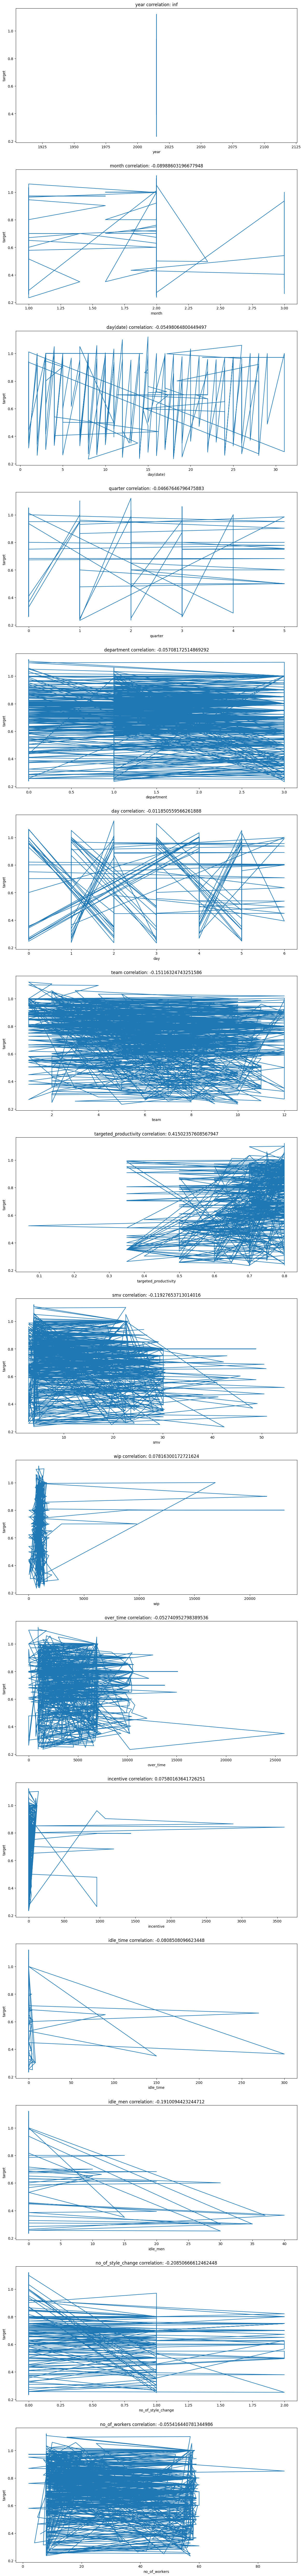

In [31]:
plot_pearson(final_imputed_gwp[:, :-1], final_imputed_gwp[:, -1], gwp_feature_names_split)

By inspection we see most values in the [-0.1, 0.1] range with a few outstanding correlations. Interestingly, year has an infinite Pearson correlation but this doesn't tell us much since every sample has the same value for year and it thus doesn't give us any meaningful indication of the target value. Therefore, we will disregard year when selecting our best values.

We will choose the eight best 50% out of the possible features (counting year, month, and day individually).

Note: SelectPercentile selects features with the highest score. With Pearson correlations, the highest absolute value matters, so we'll wrap r_regression in an absolute value function.

In [32]:
def abs_r_regression(X, y):
    return np.abs(r_regression(X, y))
    

In [33]:
gwp_selector = SelectPercentile(score_func=abs_r_regression, percentile=50)
#Skip year.
selected_gwp = np.hstack((gwp_selector.fit_transform(final_imputed_gwp[:, 1:-1],
                                                     final_imputed_gwp[:, -1]),
                          final_imputed_gwp[:, -1:]))

Those feature which were selected are:

In [34]:
print(gwp_selector.get_feature_names_out(input_features=gwp_feature_names_split[1:-1]))

['month' 'team' 'targeted_productivity' 'smv' 'idle_time' 'idle_men'
 'no_of_style_change']


<h3>Scaling</h3>
With such a wide range of values in our feature set, it's clearly important to reduce their values. We will now normalise our selected features to the range [0, 1]. We do not normalise the targets as they are already within a sufficiently small range and we don't want to distort this data.

In [36]:
scaled_gwp = np.hstack((
    MinMaxScaler(feature_range=(0, 1)).fit_transform(selected_gwp[:, :-1]),
    selected_gwp[:, -1:]))

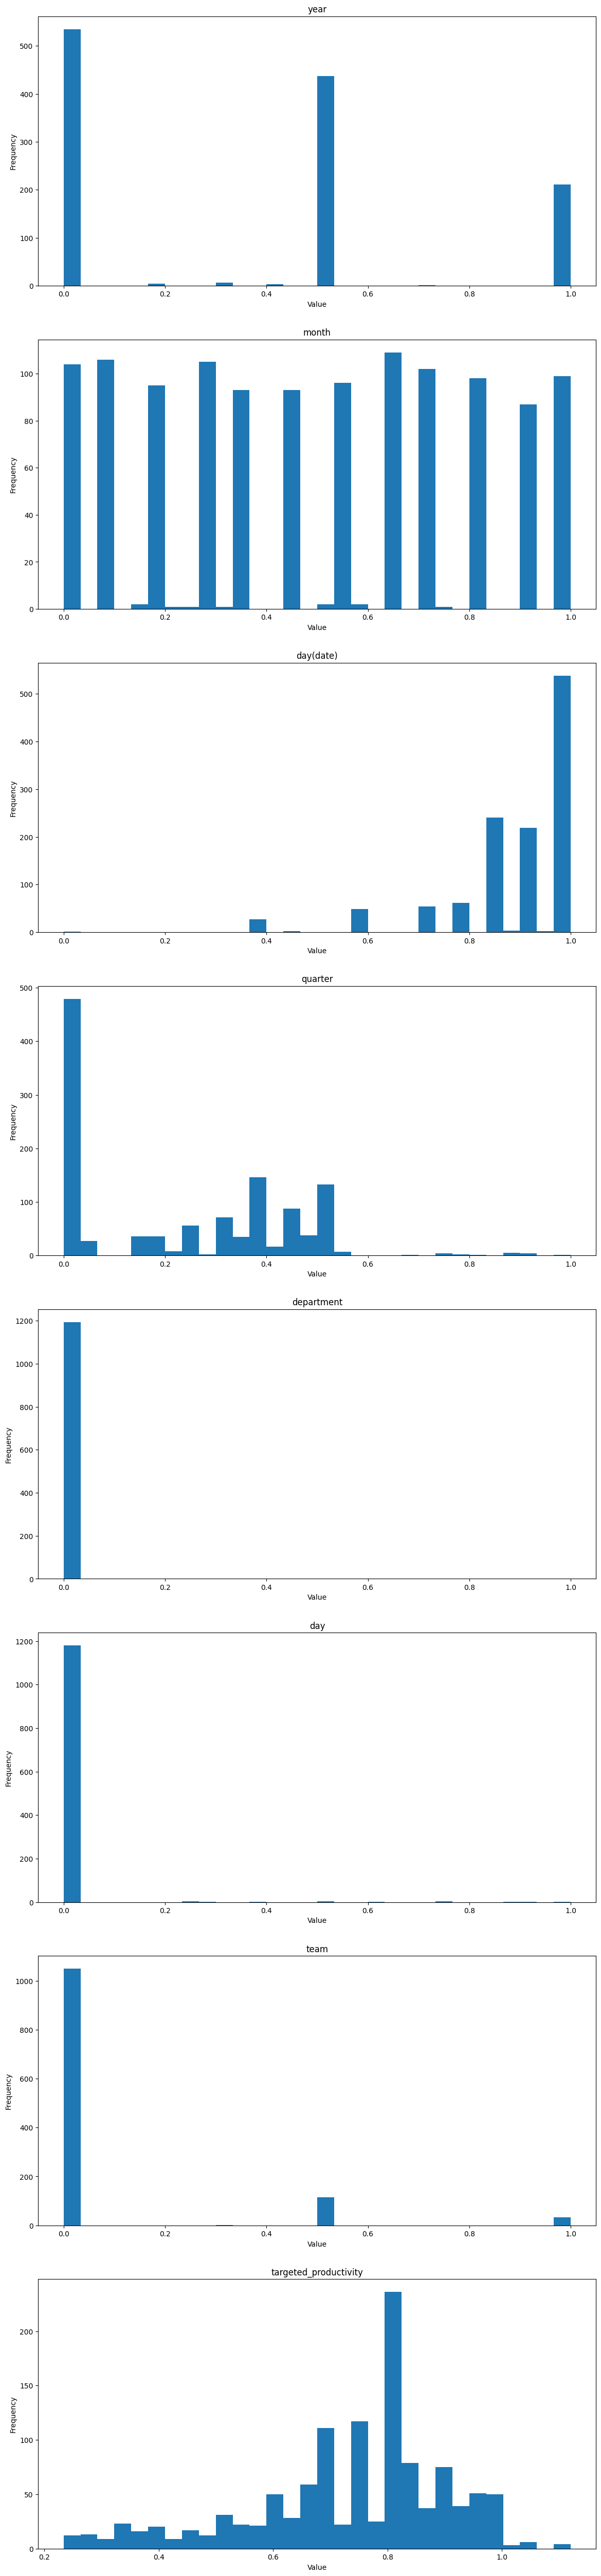

In [37]:
plot_frequency_histograms(scaled_gwp, gwp_feature_names_split)

This concludes the preprocessing and transformation of the GWP dataset.

<h2>Star Preprocessing and Transformation</h2>
In this section, we will do the preprocessing and transformation for the Star dataset. This consists of the following stages:
<ul>
    <li>Encoding the data as arrays of floating point values</li>
    <li>Imputing missing values</li>
    <li>Feature selection</li>
    <li>Scaling the data</li>
</ul>

<h3>Encoding Star Dataset</h3>
First, we transform the data from strings into appropriate numerical types for preprocessing and transformation.

The Kaggle page from which the star dataset was taken shows us that all of the features except class are numerical values and can therefore be easily casted to floating point values. As for class, we will map the values to integers using an ordinal encoder.

In [38]:
star_dataset, star_feature_names = load_star("star_assessment.csv")

In [39]:
def star_encoder(dataset, missing_value='', filling_value='nan'):
    #Impute missing values to NaN values for casting.
    dataset = SimpleImputer(missing_values=missing_value, strategy='constant',
                            fill_value=filling_value).fit_transform(
                                dataset.astype('object'))
    
    class_feature = OrdinalEncoder().fit_transform(dataset[:, -1:]).astype('float64')
    real_features = dataset[:, :-1].astype('float64')
    
    return np.hstack((real_features, class_feature))
    

In [40]:
star_encoded = star_encoder(star_dataset)

<h3>Imputation</h3>
The star dataset has a number of missing values. The following graph displays the number of missing elements from each feature.

[]

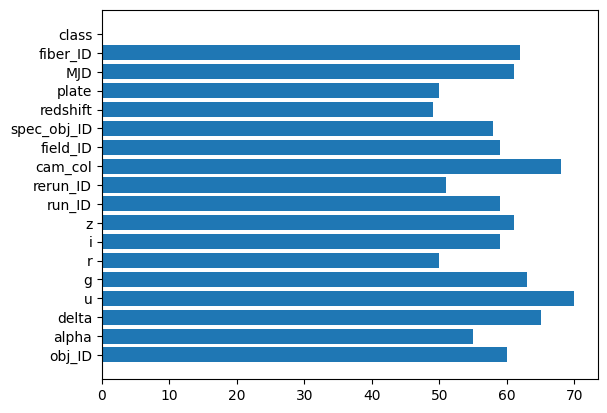

In [41]:
missing_star_fig, missing_star_ax = plt.subplots()
missing_star_ax.barh(star_feature_names, count_nan_values(star_encoded)) 
plt.plot()

A much more even distribution of missing values compared to the GWP dataset.

In [42]:
print("Number of missing entries per feature")
for i in range(0, star_feature_names.size):
    print(star_feature_names[i] + ": " + str(count_nan_values(star_encoded)[i]))

Number of missing entries per feature
obj_ID: 60.0
alpha: 55.0
delta: 65.0
u: 70.0
g: 63.0
r: 50.0
i: 59.0
z: 61.0
run_ID: 59.0
rerun_ID: 51.0
cam_col: 68.0
field_ID: 59.0
spec_obj_ID: 58.0
redshift: 49.0
plate: 50.0
MJD: 61.0
fiber_ID: 62.0
class: 0.0


<h4>Imputation Strategy</h4>
Again, we'll try several imputation strategies, including univariate imputation and multivariate imputation.

<h4>Univariate Imputation</h4>
<h5>Mean Imputation</h5>
First, we'll try imputing the data using the mean from each.

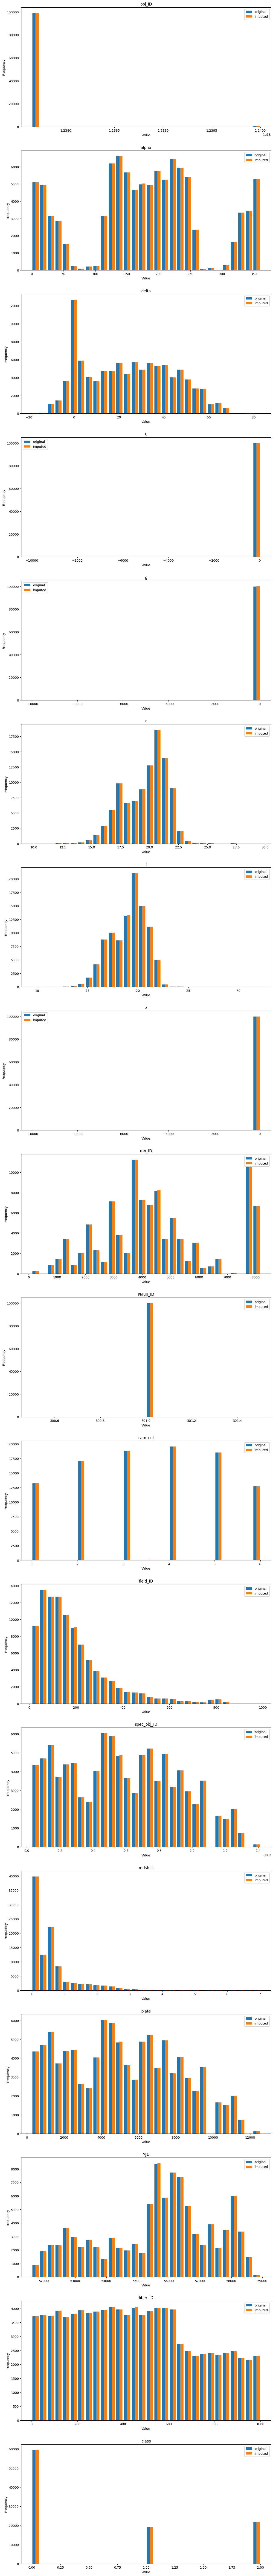

In [147]:
star_mean_imputer = SimpleImputer(missing_values=np.nan, strategy="mean", copy=True)
star_mean_imputed = star_mean_imputer.fit_transform(star_encoded)
plot_frequency_histograms(star_encoded, star_feature_names, imputed_data=star_mean_imputed, n_bins=30)

Mean imputation has kept the overall shape shape of the distributions the same. With the dataset being so large and the number of missing values for each feature being relatively small, the addition of more values with a mean value doesn't impact the distribution much. Mean imputation is definitely a viable strategy.

<h5>Median Imputation</h5>
We'll try imputing the data using the median.

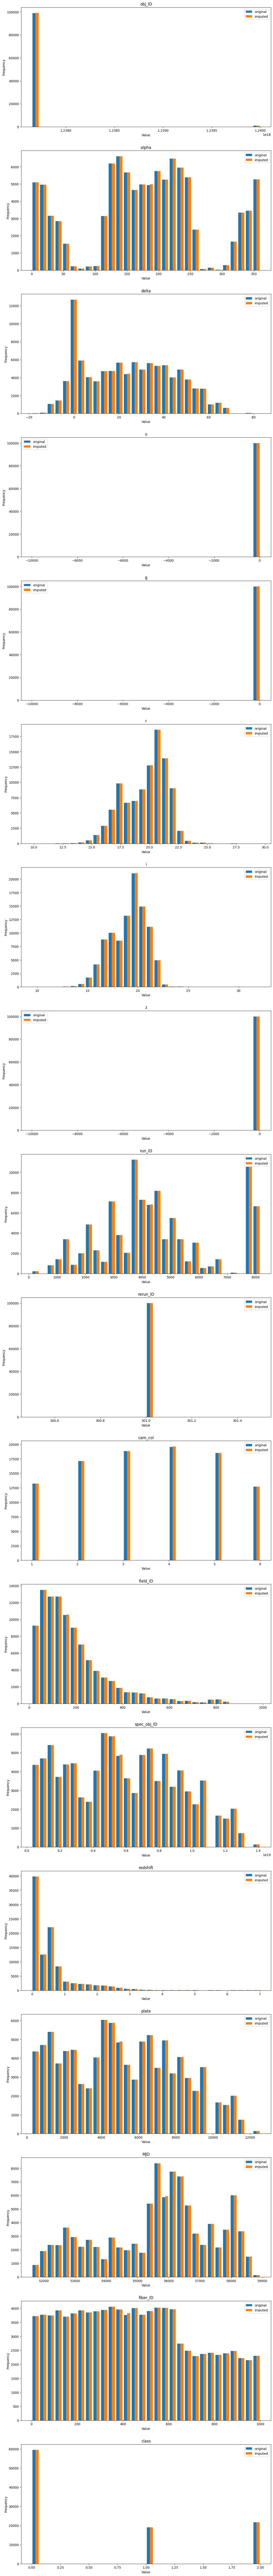

In [43]:
star_median_imputer = SimpleImputer(missing_values=np.nan, strategy="median", copy=True)
star_median_imputed = star_median_imputer.fit_transform(star_encoded)
plot_frequency_histograms(star_encoded, star_feature_names, star_median_imputed)

Similarly to mean, the median imputation keeps the distributions mostly the same.

<h4>Multivariate Imputation</h4>
<h5>KNN Imputation</h5>
We'll attempt KNN imputation.

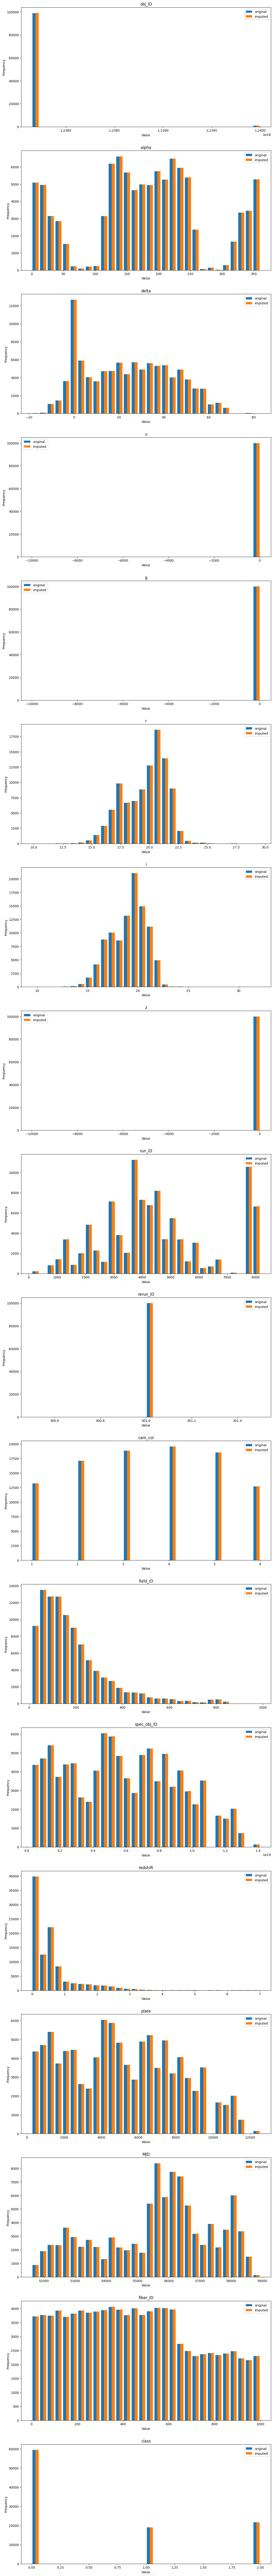

In [44]:
star_knn5_imputer = KNNImputer(missing_values=np.nan, n_neighbors=5, copy=True)
star_knn5_imputed = star_knn5_imputer.fit_transform(star_encoded)
plot_frequency_histograms(star_encoded, star_feature_names, star_knn5_imputed, n_bins=30)

Very similar distributions. More so than seen in univariate imputation.

<h5>Iterative Imputer</h5>
We'll try iterative imputation.

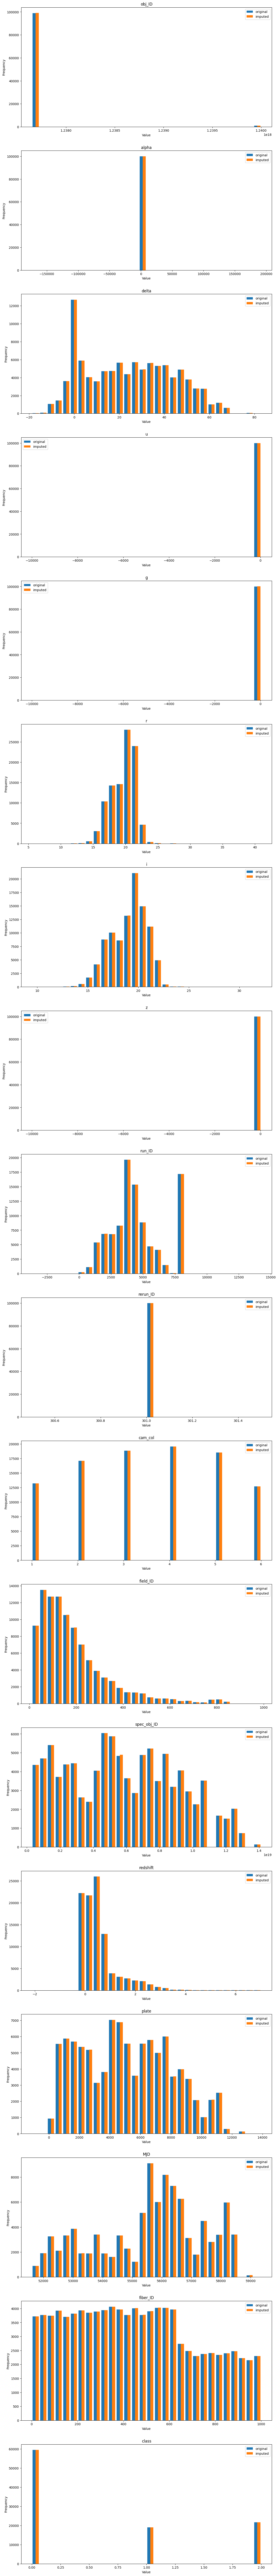

In [45]:
star_iterative_imputer = IterativeImputer(max_iter=10, missing_values=np.nan)
star_iterative_imputed = star_iterative_imputer.fit_transform(star_encoded)
plot_frequency_histograms(star_encoded, star_feature_names, star_iterative_imputed, n_bins=30)

As with KNN, it's hard to distinguish the imputed distributions from the original distributions.

KNN and iterative imputation seem equally to be the most viable. We'll stick with KNN.

In [46]:
star_knn5_imputer = KNNImputer(missing_values=np.nan, n_neighbors=5, copy=True)
star_final_imputed = star_knn5_imputer.fit_transform(star_encoded)

<h3>Scaling</h3>
We would like to use chi squared in our feature selection for this classification task. However, we can only do so with positive valued features. Since some of our features carry negative values, we normalise the data first to the range [0, 1].

In [47]:
star_scaled = np.hstack((MinMaxScaler(feature_range=(0, 1)).fit_transform(
    star_final_imputed[:, :-1]), star_final_imputed[:, -1:]))

<h3>Feature Selection</h3>
With our imputed data, we begin feature selection using filter methods. We will select the features with the greatest chi squared values.

We make a function to plot features against their chi squared values.

In [48]:
def plot_chi_squared(X, y, feature_names):
    chi2_values, p_values = chi2(X, y)
    fig, axs = plt.subplots(2, 1, figsize=(14, 16))
    axs[0].set_title("Chi Squared Values")
    axs[0].set_ylabel("Features")
    axs[0].set_xlabel("Scores")
    axs[0].barh(feature_names, chi2_values, label="chi2", align="center")
    axs[1].set_title("P values")
    axs[1].set_ylabel("Features")
    axs[1].set_xlabel("Scores")
    axs[1].barh(feature_names, p_values, label="p value", align="center")

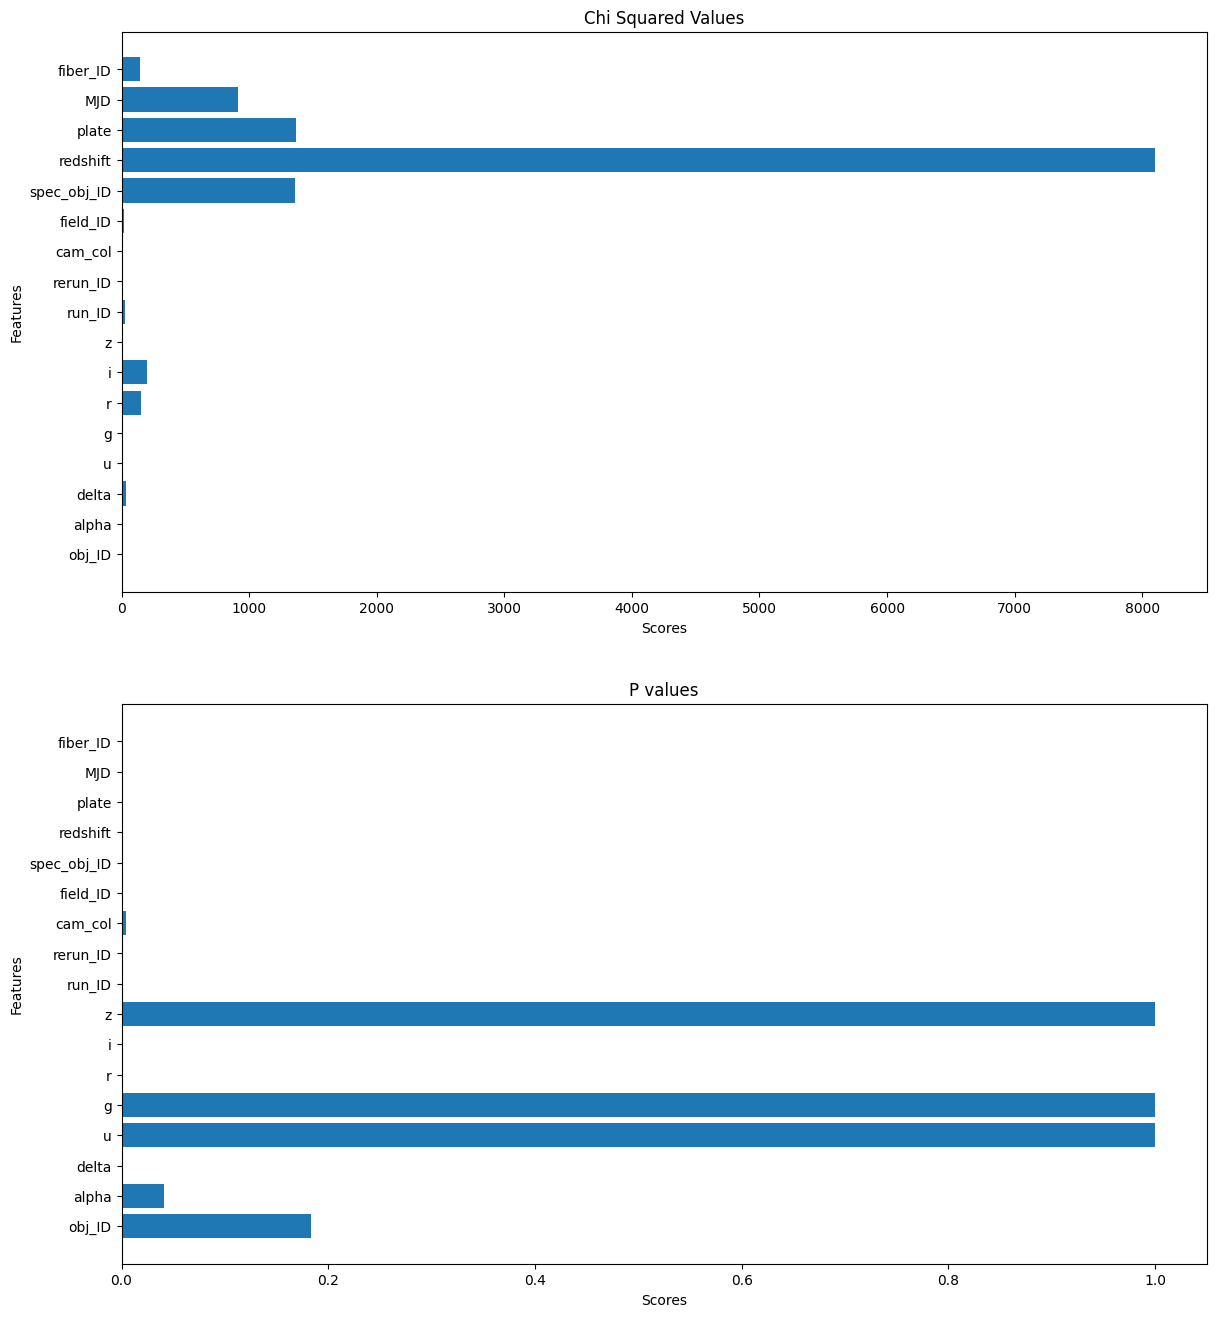

In [49]:
plot_chi_squared(X=star_scaled[:, :-1], y=star_scaled[:, -1:], feature_names=star_feature_names[:-1:])

We select the best 50% of features.

In [50]:
star_selector = SelectPercentile(score_func=chi2, percentile=50)
star_selected = np.hstack((star_selector.fit_transform(
    star_scaled[:, 0:-1], star_scaled[:, -1:]), star_scaled[:, -1:]))

In [51]:
print(star_selector.get_feature_names_out(input_features=star_feature_names[0:-1]))

['delta' 'r' 'i' 'spec_obj_ID' 'redshift' 'plate' 'MJD' 'fiber_ID']


We can see this nicely captures the best of the features.

This concludes the preprocessing and transformation of the star dataset and therefore concludes the preprocessing and transformation stage of the machine learning task.

In order to access these processed datasets in future tasks. I have written a module called mlhelper which contains classes which load and process the datasets as we have done here.

<h2>Markdown Question</h2>

The Pearson correlation coefficient measures the degree to which an increase or decrease in the value of one feature is associated with a resulting increase or decrease in the value of another feature (i.e. whether the features are correlated). Therefore, a pearson coefficient between two features which is far from zero indicates that the two features change in a way which makes it possible to predict the value of one from the other (e.g. a pearson coefficient near one tells us that as one feature increases, so does the other). 

Therefore, taking the Pearson coefficients of features against the target allows us to find which features are more effective at predicting the value of the target and thus allows us to gauge their usefulness during feature selection.